### The goal of this notebook is to create a multifaceted boxplot to describe the American Gut Cohort

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import statannot
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats


In [2]:
sns.__version__

'0.12.2'

### Load american gut metadata and filter

In [3]:
genpath='/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/'

In [4]:
# Get cdiff metadata, filter, and merge with cdiff alpha diversity data
metadata = pd.read_csv(genpath+'/american_gut_cohort/american_gut/metadata.tsv', sep = '\t', low_memory = False)
cdiff=pd.read_csv(genpath+'/american_gut_cohort/simpson/data/alpha-diversity.tsv', sep = '\t')
cdiff=cdiff.rename(columns = {'Unnamed: 0':'sample_name'})
cdiff=pd.merge(metadata, cdiff, on ='sample_name', how = 'left')

#Converting values to numeric
cdiff['height_cm'] = pd.to_numeric(cdiff['height_cm'], errors = 'coerce')
cdiff['weight_kg'] = pd.to_numeric(cdiff['weight_kg'], errors='coerce')
cdiff['age_years'] =  pd.to_numeric(cdiff['age_years'], errors='coerce')

#Filtering to only include adults, feasible heights, and average weights
cdiff=cdiff[cdiff['age_years'] >= 18].rename(columns = {'age_years':'age'})
cdiff=cdiff[(cdiff['height_cm'] <= 244) & (cdiff['height_cm'] >= 122)]
cdiff=cdiff[cdiff['weight_kg']<300]

cdiff=cdiff.reset_index(drop=True)
# # Convert BMF to numeric for regressions
norm_bmf=list()
for i in range(0,len(cdiff)):
    check = cdiff.loc[i,'bowel_movement_frequency']
    if check == 'Less than one':
        norm_bmf.append(1) #put it between one and two to match arivale df
    elif check == 'One':
        norm_bmf.append(2)
    elif check == 'Two':
        norm_bmf.append(2)
    elif check == 'Three':
        norm_bmf.append(3)
    elif check == 'Four':
        norm_bmf.append(4)
    elif check=='Five or more':
        norm_bmf.append(4)
    else:
        norm_bmf.append(float('nan'))
        
cdiff['bowel_movement_frequency']=norm_bmf

# Convert simpson to simpson 1/D
cdiff['simpson']=cdiff['simpson'].apply(lambda x:1/(1-x))

# Convert height from cm to inches so I can calculate the BMI 
cdiff['height_in']=cdiff['height_cm'].apply(lambda x: x/2.54)
cdiff['weight_lb']=cdiff['weight_kg'].apply(lambda x: x*2.205)
cdiff['BMI_CALC']= cdiff['weight_lb']/(cdiff['height_in']**2)*703

# Convert sex info to just M and F
binary_sexes=['female', 'male']
cdiff=cdiff[cdiff['sex'].isin(binary_sexes)]
cdiff['sex']=cdiff['sex'].apply(lambda x: 'F' if x=='female' else 'M')

cdiff.head()

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,vivid_dreams,weight_change,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,Not provided,Remained stable,52.0,kilograms,Never,Occasionally (1-2 times/week),6.490674,60.629921,114.66,21.927709
1,10317.000001001,Not provided,false,false,Not provided,50s,53.0,53.0,true,Rarely (a few times/month),...,Not provided,Remained stable,110.0,kilograms,Not provided,Not provided,6.588768,68.897638,242.55,35.920960
2,10317.000001002,Not provided,false,false,Not provided,50s,53.0,53.0,true,Regularly (3-5 times/week),...,Not provided,Not provided,56.0,kilograms,Not provided,Not provided,9.250269,66.141732,123.48,19.842702
3,10317.000001004,Not provided,false,false,Not provided,40s,44.0,44.0,true,Rarely (a few times/month),...,Not provided,Remained stable,86.0,kilograms,Not provided,Not provided,15.220144,61.811024,189.63,34.892372
4,10317.000001008,Not provided,false,false,Not provided,60s,66.0,66.0,false,Never,...,Not provided,Increased more than 10 pounds,74.0,kilograms,Not provided,Not provided,4.935530,61.811024,163.17,30.023669


In [5]:
cdiff.height_cm.describe()

count    13200.000000
mean       171.724318
std         10.168494
min        124.000000
25%        165.000000
50%        172.000000
75%        180.000000
max        218.000000
Name: height_cm, dtype: float64

In [6]:
cdiff.vegetable_frequency.unique()

array(['Daily', 'Not provided', 'Regularly (3-5 times/week)',
       'Occasionally (1-2 times/week)', 'Rarely (less than once/week)',
       'Never'], dtype=object)

### Create a new column that states whether the individual has been diagnosed with cdiff and categorize individuals into high and low vegetable consumption

In [7]:
# Define which responses will be a 'yes' or 'no' diagnosis
keep = ['I do not have this condition', \
        'Diagnosed by a medical professional (doctor, physician assistant)']

# just get samples where I know whether they have been diagnosed or not
cdiff = cdiff[cdiff['cdiff'].isin(keep)] 

# Make a new column for yes if diagnosed and no if not
cdiff['diagnosis'] = cdiff['cdiff'].apply(lambda x: 'yes' if x=='Diagnosed by a medical professional (doctor, physician assistant)' 
                                          else 'no')

#Filter (make new df since I'm going to lose samples for vegetable consumption responses
veggies=cdiff.copy()
veggies=veggies[veggies['vegetable_frequency']!= 'Not provided']

# low = ['Rarely (less than once/week)', 'Never']
high = ['Daily'] 
# Define high and low vegetable_consumption
veggies['vegetable_consumption'] = veggies.vegetable_frequency.apply(lambda x: 'high' if x in high else 'low')

In [8]:
veggies.vegetable_consumption.unique()

array(['high', 'low'], dtype=object)

### Create my boxplots

In [9]:
veggies.head()

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC,diagnosis,vegetable_consumption
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,52.0,kilograms,Never,Occasionally (1-2 times/week),6.490674,60.629921,114.660,21.927709,no,high
11,10317.000001031,Not provided,false,false,I do not have this condition,60s,64.0,64.0,true,Rarely (a few times/month),...,56.0,kilograms,Occasionally (1-2 times/week),Never,5.382326,70.078740,123.480,17.675812,no,low
14,10317.000001040,Not provided,false,false,I do not have this condition,70+,70.0,70.0,false,Never,...,86.0,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),NaN,61.811024,189.630,34.892372,no,low
15,10317.000001041,Not provided,false,false,I do not have this condition,50s,59.0,59.0,true,Regularly (3-5 times/week),...,61.0,kilograms,Regularly (3-5 times/week),Occasionally (1-2 times/week),7.828156,63.779528,134.505,23.245086,no,high
59,10317.000001166,I do not have this condition,false,false,I do not have this condition,40s,47.0,47.0,true,Regularly (3-5 times/week),...,74.0,kilograms,Never,Occasionally (1-2 times/week),11.089110,67.716535,163.170,25.015327,no,low


In [10]:
veggies[veggies['diagnosis']=='yes'].height_cm.describe()

count    136.000000
mean     168.073529
std       10.954879
min      152.000000
25%      161.500000
50%      167.000000
75%      175.000000
max      191.000000
Name: height_cm, dtype: float64

In [11]:
veggies[veggies['diagnosis']=='no'].height_cm.describe()

count    8977.000000
mean      171.742676
std         9.924714
min       125.000000
25%       165.000000
50%       172.000000
75%       180.000000
max       215.000000
Name: height_cm, dtype: float64

In [12]:
veggies[veggies['vegetable_consumption']=='low']['diagnosis'].value_counts().values

array([4311,   72])

In [13]:
cdiff['diagnosis'].value_counts().values

array([9072,  138])

In [14]:
len(cdiff[cdiff['diagnosis']=='yes'])

138

In [15]:
nobs=cdiff['diagnosis'].value_counts()
nobs['no']

9072

In [16]:
cdiff

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,weight_change,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC,diagnosis
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,Remained stable,52.0,kilograms,Never,Occasionally (1-2 times/week),6.490674,60.629921,114.660,21.927709,no
11,10317.000001031,Not provided,false,false,I do not have this condition,60s,64.0,64.0,true,Rarely (a few times/month),...,Remained stable,56.0,kilograms,Occasionally (1-2 times/week),Never,5.382326,70.078740,123.480,17.675812,no
14,10317.000001040,Not provided,false,false,I do not have this condition,70+,70.0,70.0,false,Never,...,Remained stable,86.0,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),NaN,61.811024,189.630,34.892372,no
15,10317.000001041,Not provided,false,false,I do not have this condition,50s,59.0,59.0,true,Regularly (3-5 times/week),...,Remained stable,61.0,kilograms,Regularly (3-5 times/week),Occasionally (1-2 times/week),7.828156,63.779528,134.505,23.245086,no
59,10317.000001166,I do not have this condition,false,false,I do not have this condition,40s,47.0,47.0,true,Regularly (3-5 times/week),...,Increased more than 10 pounds,74.0,kilograms,Never,Occasionally (1-2 times/week),11.089110,67.716535,163.170,25.015327,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13570,10317.000073338,I do not have this condition,false,false,I do not have this condition,50s,53.0,53.0,true,Occasionally (1-2 times/week),...,Remained stable,81.0,kilograms,Occasionally (1-2 times/week),Occasionally (1-2 times/week),NaN,71.653543,178.605,24.455334,no
13571,10317.000073339,I do not have this condition,false,false,I do not have this condition,30s,30.0,30.0,true,Rarely (a few times/month),...,Remained stable,74.0,kilograms,Occasionally (1-2 times/week),Regularly (3-5 times/week),NaN,63.779528,163.170,28.198957,no
13572,10317.000073340,"Diagnosed by a medical professional (doctor, p...",false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,false,Never,...,Remained stable,100.0,kilograms,Never,Daily,NaN,69.685039,220.500,31.921612,no
13573,10317.000073342,"Diagnosed by a medical professional (doctor, p...",false,false,I do not have this condition,40s,47.0,47.0,false,Never,...,Decreased more than 10 pounds,73.0,kilograms,Regularly (3-5 times/week),Regularly (3-5 times/week),NaN,71.653543,160.965,22.039992,no


In [17]:
# Get the median value for each side to display
median_simp = cdiff.groupby(['diagnosis'])['simpson'].median()
lowveg_median_simp = veggies[veggies['vegetable_consumption']=='low'].groupby(['diagnosis'])['simpson'].median()
highveg_median_simp = veggies[veggies['vegetable_consumption']=='high'].groupby(['diagnosis'])['simpson'].median()

median_height = cdiff.groupby(['diagnosis'])['height_cm'].median()
lowveg_median_height = veggies[veggies['vegetable_consumption']=='low'].groupby(['diagnosis'])['height_cm'].median()
highveg_median_height= veggies[veggies['vegetable_consumption']=='high'].groupby(['diagnosis'])['height_cm'].median()


In [18]:
print(sns.color_palette("rocket").as_hex())
purple = '#701f57'
orange = '#f37651'


['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


In [19]:
cdiff

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,weight_change,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC,diagnosis
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,Remained stable,52.0,kilograms,Never,Occasionally (1-2 times/week),6.490674,60.629921,114.660,21.927709,no
11,10317.000001031,Not provided,false,false,I do not have this condition,60s,64.0,64.0,true,Rarely (a few times/month),...,Remained stable,56.0,kilograms,Occasionally (1-2 times/week),Never,5.382326,70.078740,123.480,17.675812,no
14,10317.000001040,Not provided,false,false,I do not have this condition,70+,70.0,70.0,false,Never,...,Remained stable,86.0,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),NaN,61.811024,189.630,34.892372,no
15,10317.000001041,Not provided,false,false,I do not have this condition,50s,59.0,59.0,true,Regularly (3-5 times/week),...,Remained stable,61.0,kilograms,Regularly (3-5 times/week),Occasionally (1-2 times/week),7.828156,63.779528,134.505,23.245086,no
59,10317.000001166,I do not have this condition,false,false,I do not have this condition,40s,47.0,47.0,true,Regularly (3-5 times/week),...,Increased more than 10 pounds,74.0,kilograms,Never,Occasionally (1-2 times/week),11.089110,67.716535,163.170,25.015327,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13570,10317.000073338,I do not have this condition,false,false,I do not have this condition,50s,53.0,53.0,true,Occasionally (1-2 times/week),...,Remained stable,81.0,kilograms,Occasionally (1-2 times/week),Occasionally (1-2 times/week),NaN,71.653543,178.605,24.455334,no
13571,10317.000073339,I do not have this condition,false,false,I do not have this condition,30s,30.0,30.0,true,Rarely (a few times/month),...,Remained stable,74.0,kilograms,Occasionally (1-2 times/week),Regularly (3-5 times/week),NaN,63.779528,163.170,28.198957,no
13572,10317.000073340,"Diagnosed by a medical professional (doctor, p...",false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,false,Never,...,Remained stable,100.0,kilograms,Never,Daily,NaN,69.685039,220.500,31.921612,no
13573,10317.000073342,"Diagnosed by a medical professional (doctor, p...",false,false,I do not have this condition,40s,47.0,47.0,false,Never,...,Decreased more than 10 pounds,73.0,kilograms,Regularly (3-5 times/week),Regularly (3-5 times/week),NaN,71.653543,160.965,22.039992,no


In [20]:
cdiff[cdiff['diagnosis']=='yes']['simpson']

153      6.617622
854           NaN
855      3.989694
1033     6.202267
1123     3.040463
           ...   
13196         NaN
13345         NaN
13503         NaN
13516         NaN
13528         NaN
Name: simpson, Length: 138, dtype: float64

In [21]:
# Get pvalues for Welch's t-test
results = stats.ttest_ind(cdiff[cdiff['diagnosis']=='yes']['simpson'].dropna(), cdiff[cdiff['diagnosis']=='no']['simpson'].dropna(), equal_var=False)
pvalue = results.pvalue
corrected = pvalue*3
print(f'pvalue={pvalue:2E}, corrected={corrected:2E}, t={results.statistic}')
# Bonferroni correction
pvalue=pvalue/3
pvalue

pvalue=8.063450E-06, corrected=2.419035E-05, t=-4.758757065895591


2.687816807947801e-06

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no vs. yes: 2.42E-05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no vs. yes: 5.02E-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no vs. yes: 5.17E-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no vs. yes: 4.21E-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-

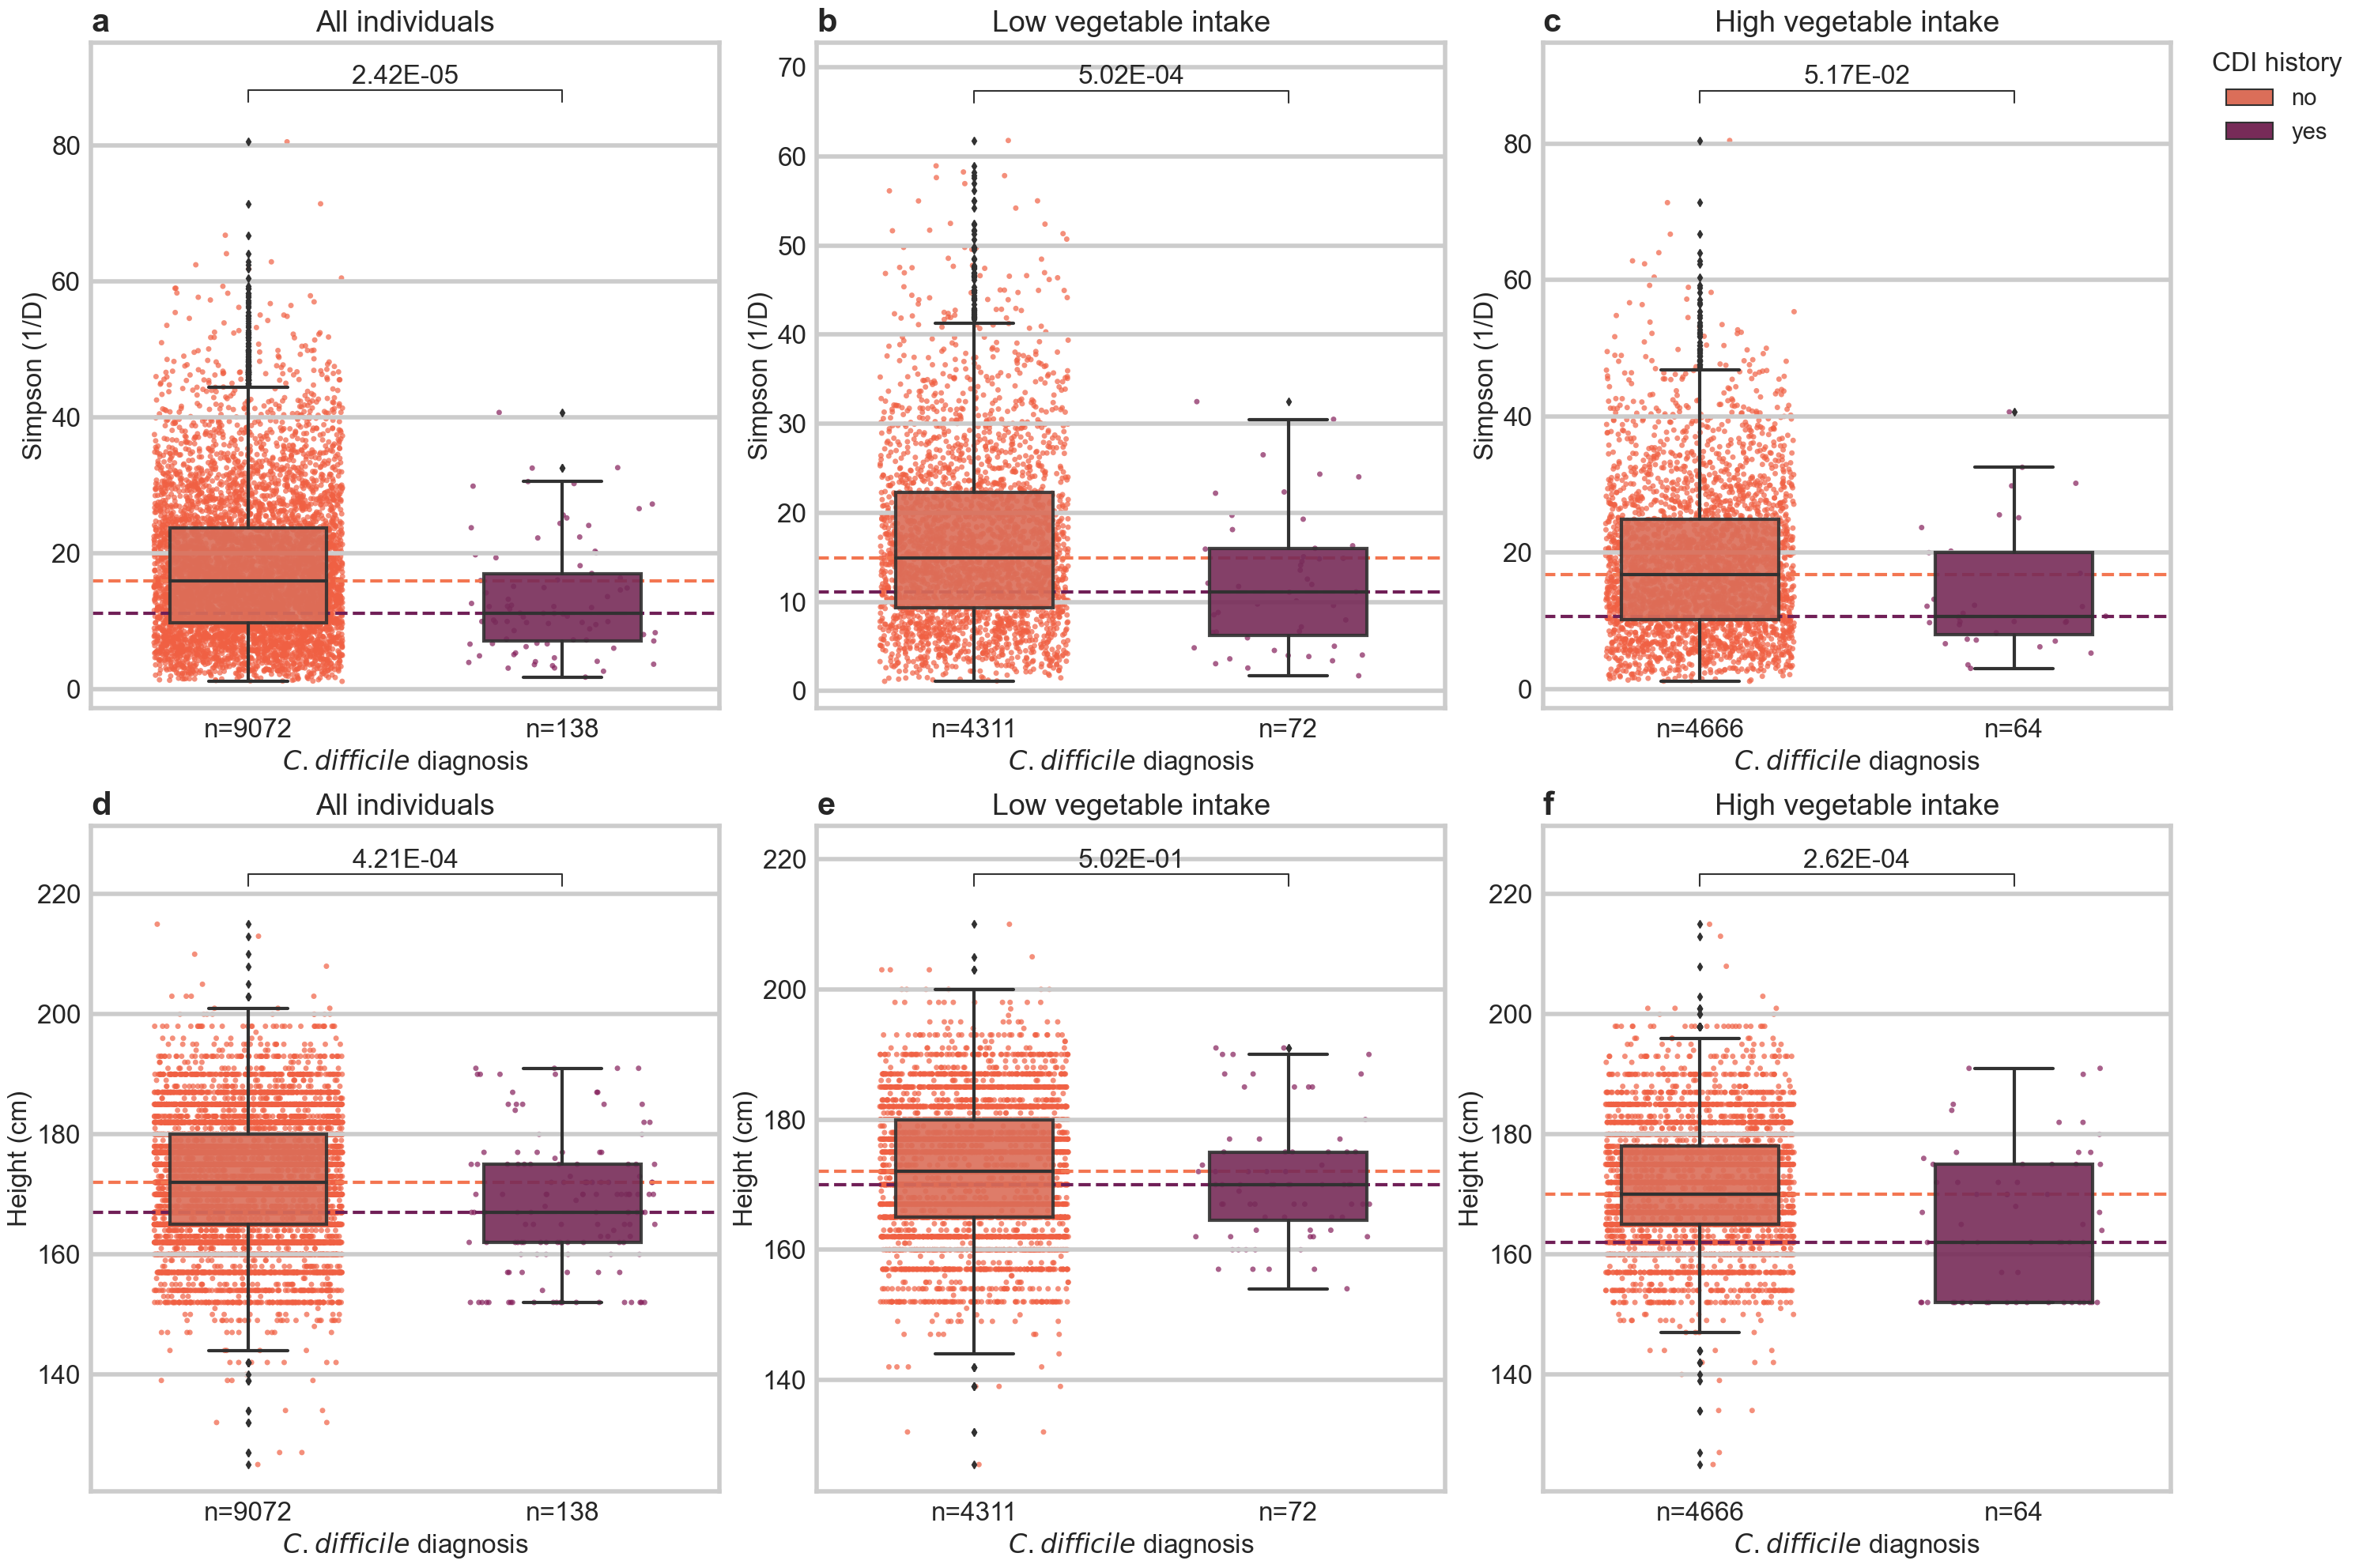

In [34]:
from statannotations.Annotator import Annotator

# sns.set_theme(style='whitegrid',font_scale=2.5)
size = 30
fig, axs = plt.subplots(2,3,figsize=(30,20), tight_layout=True)
params= {'axes.labelsize':size*0.8,
         'axes.titlesize':size*0.9, 
         'xtick.labelsize':size*0.8,
         'ytick.labelsize':size*0.8, 
         'axes.titlepad':10, 
         'grid.linewidth':4,
         'lines.linewidth':3,
         'axes.linewidth':4,
         'figure.subplot.hspace':0.9, 
         'figure.subplot.wspace':0.9,
         'font.family':'sans-serif',
         'font.sans-serif':'Arial',
         'patch.force_edgecolor': True}
plt.rcParams.update(params)
sns.set_theme(style='whitegrid', rc=params)


# Plot labels
axs[0,0].set_title('a', loc='left', fontweight='bold',fontsize=size)
axs[0,1].set_title('b', loc='left', fontweight='bold', fontsize=size)
axs[0,2].set_title('c', loc='left', fontweight='bold', fontsize=size)
axs[1,0].set_title('d', loc='left', fontweight='bold', fontsize=size)
axs[1,1].set_title('e', loc='left', fontweight='bold', fontsize=size)
axs[1,2].set_title('f', loc='left', fontweight='bold', fontsize=size)

x = 'diagnosis'
y = 'simpson'

#Observations by group
nobs = cdiff['diagnosis'].value_counts()
low_nobs = veggies[veggies['vegetable_consumption']=='low']
low_nobs = low_nobs['diagnosis'].value_counts()
high_nobs = veggies[veggies['vegetable_consumption']=='high']
high_nobs = high_nobs['diagnosis'].value_counts()

axs[0,0] = sns.boxplot(data=cdiff, x=x, y=y, ax=axs[0,0], palette='rocket_r', boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[0,0]=sns.stripplot(data=cdiff, x=x, y=y, ax=axs[0,0], palette='rocket_r', alpha=0.7, jitter=0.3, zorder=0)
axs[0,0].legend([],[],frameon=False)
axs[0,0].set_xticklabels([f"n={nobs['no']}", f"n={nobs['yes']}"])
axs[0,0].set(xlabel='$C. difficile$ diagnosis', ylabel='Simpson (1/D)', title='All individuals')

axs[0,0].hlines(y=median_simp['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[0,0].hlines(y=median_simp['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

# # Get pvalues for Welch's t-test and apply Bonferroni correction
pvalue = stats.ttest_ind(cdiff[cdiff['diagnosis']=='yes']['simpson'].dropna(), cdiff[cdiff['diagnosis']=='no']['simpson'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']
annotator = Annotator(ax=axs[0,0], pairs=[('yes', 'no')], data=cdiff, x=x, y=y)
annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()
                         
axs[0,1] = sns.boxplot(data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[0,1],boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[0,1] = sns.stripplot(data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[0,1], alpha = 0.7, jitter=0.3, zorder=0)
axs[0,1].legend([],[],frameon=False)
axs[0,1].set_xticklabels([f"n={low_nobs['no']}", f"n={low_nobs['yes']}"])
axs[0,1].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Simpson (1/D)', title='Low vegetable intake') 

annotator = Annotator(ax=axs[0,1], pairs=[('yes', 'no')], data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y)
pvalue = stats.ttest_ind(veggies[(veggies['vegetable_consumption']=='low')&(veggies['diagnosis']=='yes')]['simpson'].dropna(), veggies[(veggies['vegetable_consumption']=='low')&(veggies['diagnosis']=='no')]['simpson'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']

annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()
axs[0,1].hlines(y=lowveg_median_simp['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[0,1].hlines(y=lowveg_median_simp['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

axs[0,2] = sns.boxplot(ax=axs[0,2],data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[0,2] = sns.stripplot(ax=axs[0,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', alpha = 0.7, jitter=0.3, zorder=0)
axs[0,2].legend(title='CDI history', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=size*0.7, title_fontsize=size*0.8, frameon=False)
axs[0,2].set_xticklabels([f"n={high_nobs['no']}", f"n={high_nobs['yes']}"])
axs[0,2].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Simpson (1/D)', title='High vegetable intake')

annotator = Annotator(ax=axs[0,2], pairs=[('yes','no')], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y)
pvalue = stats.ttest_ind(veggies[(veggies['vegetable_consumption']=='high')&(veggies['diagnosis']=='yes')]['simpson'].dropna(), veggies[(veggies['vegetable_consumption']=='high')&(veggies['diagnosis']=='no')]['simpson'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']
annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()

axs[0,2].hlines(y=highveg_median_simp['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[0,2].hlines(y=highveg_median_simp['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

x = 'diagnosis'
y = 'height_cm'

axs[1,0] = sns.boxplot(data =cdiff, x=x, y=y, ax=axs[1,0], palette='rocket_r', boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[1,0] = sns.stripplot(data=cdiff, x=x, y=y, ax=axs[1,0], palette='rocket_r', alpha = 0.7, jitter=0.3, zorder=0)
axs[1,0].legend([],[],frameon=False)
axs[1,0].set_xticklabels([f"n={nobs['no']}", f"n={nobs['yes']}"])
axs[1,0].set(xlabel='$C. difficile$ diagnosis', ylabel='Height (cm)', title='All individuals')

annotator=Annotator(ax=axs[1,0], pairs=[('yes', 'no')], data=cdiff, x=x, y=y)
pvalue = stats.ttest_ind(cdiff[cdiff['diagnosis']=='yes']['height_cm'].dropna(), cdiff[cdiff['diagnosis']=='no']['height_cm'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']
annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()

axs[1,0].hlines(y=median_height['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[1,0].hlines(y=median_height['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

axs[1,1] = sns.boxplot(data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[1,1], boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[1,1] = sns.stripplot(data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[1,1], alpha=0.7, jitter=0.3, zorder=0)
axs[1,1].legend([],[],frameon=False)
axs[1,1].set_xticklabels([f"n={low_nobs['no']}", f"n={low_nobs['yes']}"])
axs[1,1].set(xlabel='$C. difficile$ diagnosis', ylabel = 'Height (cm)', title='Low vegetable intake')

annotator=Annotator(ax=axs[1,1], pairs=[('yes','no')], data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y)
pvalue = stats.ttest_ind(veggies[(veggies['vegetable_consumption']=='low')&(veggies['diagnosis']=='yes')]['height_cm'].dropna(), veggies[(veggies['vegetable_consumption']=='low')&(veggies['diagnosis']=='no')]['height_cm'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']
annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()

axs[1,1].hlines(y=lowveg_median_height['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[1,1].hlines(y=lowveg_median_height['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

axs[1,2] = sns.boxplot(ax=axs[1,2],data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', boxprops=dict(alpha=0.9), width=0.5, hue='diagnosis', dodge=False)
axs[1,2] = sns.stripplot(ax=axs[1,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', alpha=0.7, jitter=0.3, zorder=0)
axs[1,2].legend([],[],frameon=False)
axs[1,2].set_xticklabels([f"n={high_nobs['no']}", f"n={high_nobs['yes']}"])
axs[1,2].set(xlabel='$C. difficile$ diagnosis', ylabel = 'Height (cm)', title='High vegetable intake')

annotator=Annotator(ax=axs[1,2], pairs=[('yes', 'no')], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y)
pvalue = stats.ttest_ind(veggies[(veggies['vegetable_consumption']=='high')&(veggies['diagnosis']=='yes')]['height_cm'].dropna(), veggies[(veggies['vegetable_consumption']=='high')&(veggies['diagnosis']=='no')]['height_cm'].dropna(), equal_var=False).pvalue
pvalue=pvalue*3
pvalue = [f'{pvalue:.2E}']
annotator.configure(fontsize=size*0.8).set_custom_annotations(pvalue).annotate()

axs[1,2].hlines(y=highveg_median_height['no'], xmin=-0.5, xmax=1.5, color=orange, linewidths=3, linestyles='dashed', zorder=0)
axs[1,2].hlines(y=highveg_median_height['yes'], xmin=-0.5, xmax=1.5, color=purple, linewidths=3, linestyles='dashed', zorder=0)

In [35]:
fig.savefig(genpath+'/output/cdiff_boxplots.pdf', bbox_inches='tight')
fig.savefig(genpath+'/output/cdiff_boxplots.png', bbox_inches='tight')

### Clean up data for regressions

In [24]:
# Make new df for regressions
data=veggies.copy()
data=data[['diagnosis', 'height_cm', 'age', 'sex', 'BMI_CALC', 'vegetable_consumption', 'simpson', 'bowel_movement_frequency']].dropna().reset_index(drop=True)

## Standardize data
features=['height_cm', 'age', 'BMI_CALC', 'simpson']
data[features]=data[features].apply(lambda x: (x - x.mean()) / x.std())

# Make CDI history and veggie consumption binomial 
data=data.sort_values(by='vegetable_consumption', ascending=True)
data['has_cdiff']=data['diagnosis'].apply(lambda x: 1 if x=='yes' else 0)
data['high_vegetable_consumption']=data['vegetable_consumption'].apply(lambda x: 1 if x=='high' else 0)
data
data.head()

,diagnosis,height_cm,age,sex,BMI_CALC,vegetable_consumption,simpson,bowel_movement_frequency,has_cdiff,high_vegetable_consumption
0,no,-1.762137,1.052606,F,-0.487131,high,-1.058295,2.0,0,1
3032,no,-0.951492,0.650427,F,1.185864,high,-0.562655,2.0,0,1
3035,no,1.581772,0.248247,M,2.550256,high,0.244314,2.0,0,1
3038,no,-0.951492,1.186666,F,-0.527577,high,-0.715276,2.0,0,1
3040,no,-0.647501,-0.287992,F,-0.321521,high,-1.122181,2.0,0,1


In [25]:
# Save this df to csv so I can run the mediation analysis on it in R
data.to_csv(genpath+'/american_gut_cohort/american_gut_filtered_standardized.csv')

### GLM regressions

In [26]:
# formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  height_cm + high_vegetable_consumption'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

In [27]:
# ###### formula = 'has_cdiff ~ height_cm'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

In [28]:
# formula = 'has_cdiff ~ high_vegetable_consumption'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

In [29]:
# formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  height_cm'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

In [30]:
# formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  high_vegetable_consumption'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

In [31]:
# formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + simpson'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())

### Checking for interaction effects between height and diet
### OLS: Simpson versus height, diet, and height:diet

In [32]:
# formula='simpson ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + high_vegetable_consumption + height_cm + height_cm:high_vegetable_consumption'
# model=smf.ols(formula=formula, data=data).fit()
# print(model.summary())

### GLM: CDI versus height,diet, and height:diet

In [33]:
#Redacted to avoid statistical double dipping
# formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + simpson + height_cm + high_vegetable_consumption + height_cm:high_vegetable_consumption'
# model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
# print(model.summary())